In [1]:
# In this notebook we plot the error (both ELPP and MSE) of GPC as a function of number of training data points

In [2]:
import logging
import time

import pyDOE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.models.bfgpc import BFGPC_ELBO
from src.problems.toy_example import create_smooth_change_nonlinear

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
get_LF_probs, get_HF_probs, _, _ = create_smooth_change_nonlinear()

def sample_LF_outcomes(X_normalized):  # Expects N x 2 normalized input
    Y_linear_low_grid, probs_linear_low_grid = get_LF_probs(X_normalized, reps=1)
    Y_linear_high_grid = Y_linear_low_grid.mean(axis=0)
    return Y_linear_high_grid

def sample_HF_outcomes(X_normalized):
    Y_linear_high_grid, probs_linear_high_grid = get_HF_probs(X_normalized, reps=1)
    Y_linear_high_grid = Y_linear_high_grid.mean(axis=0).astype(int)
    return Y_linear_high_grid

X_test = pyDOE.lhs(2, samples=10_000)
Y_test = sample_HF_outcomes(X_test)
_, p_test_true = get_HF_probs(X_test)

In [4]:
Y_test

array([1, 0, 1, ..., 0, 0, 1], shape=(10000,))

In [8]:
N_reps = 3

def train_eval_gpc(N_train):
    elpps = []
    mses = []
    for _ in range(N_reps):
        X_train = pyDOE.lhs(2, N_train)
        Y_train = sample_HF_outcomes(X_train)

        kernel = 1.0 * RBF(length_scale=1.0)
        model = GaussianProcessClassifier(kernel=kernel)
        model.fit(X_train, Y_train)

        # ELPP
        probas = model.predict_proba(X_test)
        num_test_samples = len(Y_test)
        correct_class_probas = probas[np.arange(num_test_samples), Y_test]
        log_predictive_probas = np.log(correct_class_probas)
        elpp = np.mean(log_predictive_probas)

        # MSE of probs
        mse = np.mean((probas[np.arange(num_test_samples), 1] - p_test_true)**2)

        elpps.append(elpp)
        mses.append(mse)

    return {'elpp': np.mean(elpps), 'mse': np.mean(mses)}

def train_eval_bfgpc(N_train_LF, N_train_HF):
    elpps = []
    mses = []
    for _ in range(N_reps):
        X_train_LF = pyDOE.lhs(2, N_train_LF)
        X_train_HF = pyDOE.lhs(2, N_train_HF)
        Y_train_LF = sample_LF_outcomes(X_train_LF)
        Y_train_HF = sample_HF_outcomes(X_train_HF)

        model = BFGPC_ELBO(n_inducing_pts=N_train_HF // 2)
        model.train_model(X_train_LF, Y_train_LF, X_train_HF, Y_train_HF, n_epochs=N_train_HF, lr=0.1)

        # ELPP
        elpp = model.evaluate_elpp(X_test, Y_test)

        # MSE
        probs = model.predict_hf_prob(X_test)
        mse = np.mean((probs - p_test_true)**2)

        elpps.append(elpp)
        mses.append(mse)

    return {'elpp': np.mean(elpps), 'mse': np.mean(mses)}





--- Starting GPC vs. BFGPC Convergence Comparison ---
Running GPC with N_H=5...
Finished in 0.03s. RMSE: 0.3528, ELPP: -0.6143
Running BFGPC with N_L=1000, N_H=5...
Finished in 5.18s. RMSE: 0.3509, ELPP: -0.6116
Running GPC with N_H=10...
Finished in 0.03s. RMSE: 0.3162, ELPP: -0.5582
Running BFGPC with N_L=1000, N_H=10...
Finished in 5.69s. RMSE: 0.2325, ELPP: -0.4439
Running GPC with N_H=20...
Finished in 0.03s. RMSE: 0.1905, ELPP: -0.4047
Running BFGPC with N_L=1000, N_H=20...
Finished in 6.13s. RMSE: 0.2244, ELPP: -0.4608
Running GPC with N_H=50...
Finished in 0.04s. RMSE: 0.1356, ELPP: -0.3502
Running BFGPC with N_L=1000, N_H=50...
Finished in 9.21s. RMSE: 0.1150, ELPP: -0.3285
Running GPC with N_H=100...
Finished in 0.06s. RMSE: 0.1243, ELPP: -0.3402
Running BFGPC with N_L=1000, N_H=100...
Finished in 13.90s. RMSE: 0.1331, ELPP: -0.3450
Running GPC with N_H=150...
Finished in 0.11s. RMSE: 0.1297, ELPP: -0.3449
Running BFGPC with N_L=1000, N_H=150...
Finished in 24.06s. RMSE: 0.0

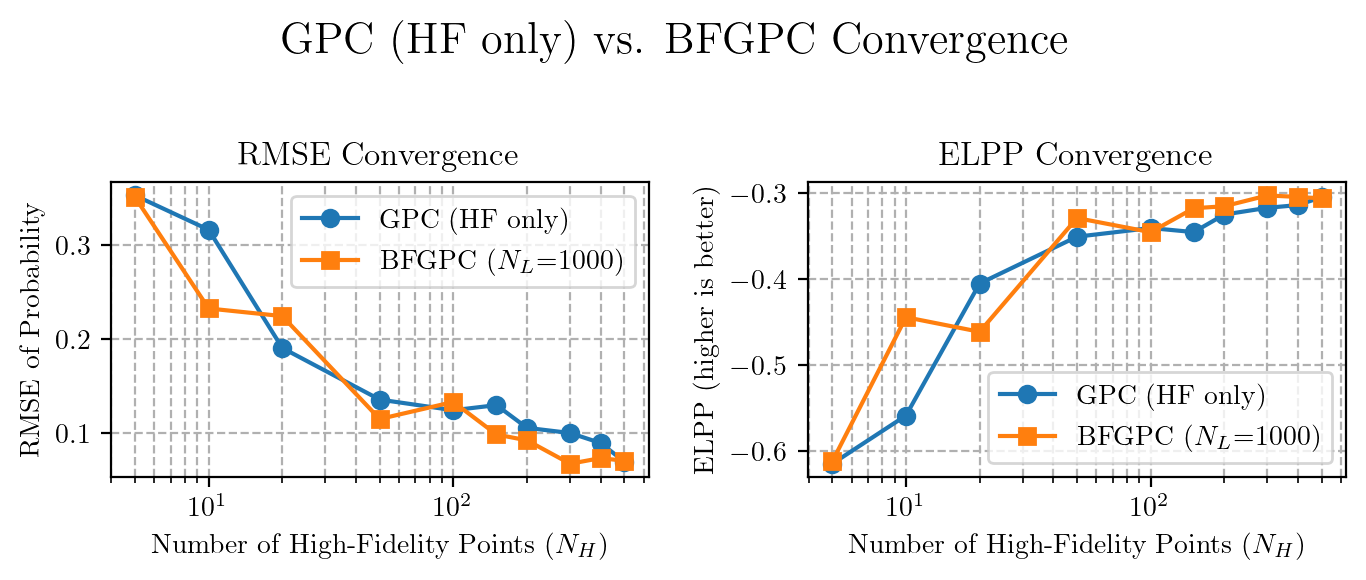

In [9]:

# Section 2: Direct Comparison between GPC (HF only) and BFGPC
# We fix the number of low-fidelity points for the BFGPC to a large value
# and compare convergence against a standard GPC as N_H increases.

print("\n--- Starting GPC vs. BFGPC Convergence Comparison ---")

N_H_comparison_vals = np.array([5, 10, 20, 50, 100, 150, 200, 300, 400, 500])
N_L_fixed = 1000  # A large, fixed number of LF points for the BFGPC

# Lists to store results
gpc_results = []
bfgpc_results = []

for n_h in N_H_comparison_vals:
    # Train and evaluate the single-fidelity GPC
    print(f"Running GPC with N_H={n_h}...")
    start_time = time.time()
    gpc_res = train_eval_gpc(n_h)
    gpc_results.append(gpc_res)
    end_time = time.time()
    print(f"Finished in {end_time - start_time:.2f}s. RMSE: {np.sqrt(gpc_res['mse']):.4f}, ELPP: {gpc_res['elpp']:.4f}")

    # Train and evaluate the bi-fidelity BFGPC
    print(f"Running BFGPC with N_L={N_L_fixed}, N_H={n_h}...")
    start_time = time.time()
    bfgpc_res = train_eval_bfgpc(N_L_fixed, n_h)
    bfgpc_results.append(bfgpc_res)
    end_time = time.time()
    print(
        f"Finished in {end_time - start_time:.2f}s. RMSE: {np.sqrt(bfgpc_res['mse']):.4f}, ELPP: {bfgpc_res['elpp']:.4f}")

# Convert results to numpy arrays for easier plotting
gpc_rmses = np.array([np.sqrt(r['mse']) for r in gpc_results])
gpc_elpps = np.array([r['elpp'] for r in gpc_results])

bfgpc_rmses = np.array([np.sqrt(r['mse']) for r in bfgpc_results])
bfgpc_elpps = np.array([r['elpp'] for r in bfgpc_results])

print("\n--- GPC vs. BFGPC Comparison Finished ---")

# Plotting the comparison results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=200, sharex=True)
fig.suptitle('GPC (HF only) vs. BFGPC Convergence', fontsize=16)

# Plot RMSE comparison
ax1.plot(N_H_comparison_vals, gpc_rmses, 'o-', label='GPC (HF only)')
ax1.plot(N_H_comparison_vals, bfgpc_rmses, 's-', label=f'BFGPC ($N_L$={N_L_fixed})')
ax1.set_xlabel('Number of High-Fidelity Points ($N_H$)')
ax1.set_ylabel('RMSE of Probability')
ax1.set_title('RMSE Convergence')
ax1.set_xscale('log')
ax1.grid(True, which="both", ls="--")
ax1.legend()

# Plot ELPP comparison
ax2.plot(N_H_comparison_vals, gpc_elpps, 'o-', label='GPC (HF only)')
ax2.plot(N_H_comparison_vals, bfgpc_elpps, 's-', label=f'BFGPC ($N_L$={N_L_fixed})')
ax2.set_xlabel('Number of High-Fidelity Points ($N_H$)')
ax2.set_ylabel('ELPP (higher is better)')
ax2.set_title('ELPP Convergence')
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:

print("--- Starting BFGPC 2D Convergence Study ---")

# Define the grid of low-fidelity and high-fidelity sample sizes
N_L_vals = np.array([50, 100, 500, 1000, 2000])
N_H_vals = np.array([5, 10, 25, 50, 100, 250, 500])

# Initialize grids to store results
rmse_grid = np.zeros((len(N_L_vals), len(N_H_vals)))
elpp_grid = np.zeros((len(N_L_vals), len(N_H_vals)))

# Loop through each combination of N_L and N_H
for i, n_l in enumerate(N_L_vals):
    for j, n_h in enumerate(N_H_vals):
        print(f"Running BFGPC with N_L={n_l}, N_H={n_h}...")
        start_time = time.time()

        # To make results more stable, one could average over several runs.
        # For this example, we perform a single run.
        results = train_eval_bfgpc(n_l, n_h)

        rmse_grid[i, j] = np.sqrt(results['mse'])
        elpp_grid[i, j] = results['elpp']

        end_time = time.time()
        print(f"Finished in {end_time - start_time:.2f}s. RMSE: {rmse_grid[i, j]:.4f}, ELPP: {elpp_grid[i, j]:.4f}")

print("\n--- BFGPC 2D Convergence Study Finished ---")

# Plotting the contour plots for BFGPC performance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot RMSE Contour
c1 = ax1.contourf(N_H_vals, N_L_vals, rmse_grid, levels=15, cmap='viridis_r')
fig.colorbar(c1, ax=ax1, label='RMSE of Probability')
ax1.set_title('BFGPC: RMSE vs. Number of Training Points')
ax1.set_xlabel('Number of High-Fidelity Points ($N_H$)')
ax1.set_ylabel('Number of Low-Fidelity Points ($N_L$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks(N_H_vals)
ax1.set_xticklabels(N_H_vals)
ax1.set_yticks(N_L_vals)
ax1.set_yticklabels(N_L_vals)

# Plot ELPP Contour
c2 = ax2.contourf(N_H_vals, N_L_vals, elpp_grid, levels=15, cmap='viridis')
fig.colorbar(c2, ax=ax2, label='Expected Log Pointwise Predictive Probability (ELPP)')
ax2.set_title('BFGPC: ELPP vs. Number of Training Points')
ax2.set_xlabel('Number of High-Fidelity Points ($N_H$)')
ax2.set_ylabel('Number of Low-Fidelity Points ($N_L$)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xticks(N_H_vals)
ax2.set_xticklabels(N_H_vals)
ax2.set_yticks(N_L_vals)
ax2.set_yticklabels(N_L_vals)

plt.tight_layout()
plt.show()
